<h1 style="
    font-family: 'Arial', sans-serif;
    font-size: 2.5em;
    background: linear-gradient(90deg, #FF7F50, #1E90FF);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    text-align: center;
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3);
    margin-bottom: 20px;
    padding: 10px;
">
  Import Libraries
</h1>

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc, roc_curve, precision_score, recall_score
from sklearn.preprocessing import RobustScaler
from imblearn.under_sampling import RandomUnderSampler  
import seaborn as sns

<h1 style="
    font-family: 'Arial', sans-serif;
    font-size: 2.5em;
    background: linear-gradient(90deg, #FF7F50, #1E90FF);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    text-align: center;
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3);
    margin-bottom: 20px;
    padding: 10px;
">
  Loading the Dataset
</h1>

In [3]:
df = pd.read_csv("star_classification.csv")

In [4]:
df.head(10)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
5,1.237680e+18,340.995121,20.589476,23.48827,23.33776,21.32195,20.25615,19.54544,8102,301,3,110,5.658977e+18,QSO,1.424659,5026,55855,741
6,1.237679e+18,23.234926,11.418188,21.46973,21.17624,20.92829,20.60826,20.42573,7773,301,2,462,1.246262e+19,QSO,0.586455,11069,58456,113
7,1.237679e+18,5.433176,12.065186,22.24979,22.02172,20.34126,19.48794,18.84999,7773,301,2,346,6.961443e+18,GALAXY,0.477009,6183,56210,15
8,1.237661e+18,200.290475,47.199402,24.40286,22.35669,20.61032,19.46490,18.95852,3716,301,5,108,7.459285e+18,GALAXY,0.660012,6625,56386,719
9,1.237671e+18,39.149691,28.102842,21.74669,20.03493,19.17553,18.81823,18.65422,5934,301,4,122,2.751763e+18,STAR,-0.000008,2444,54082,232


<h1 style="
    font-family: 'Arial', sans-serif;
    font-size: 2.5em;
    background: linear-gradient(90deg, #FF7F50, #1E90FF);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    text-align: center;
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3);
    margin-bottom: 20px;
    padding: 10px;
">
  Preprocessing the Dataset
</h1>

In [5]:
# let's remove some columns from the dataset that are not useful and do not make sense in the dataset.
df.drop(["obj_ID", "run_ID", "rerun_ID", "field_ID", "spec_obj_ID", "fiber_ID"], axis=1, inplace=True)


In [6]:
# Using the Encoder tp convert class to the numbers

le = LabelEncoder()
df["class"] = le.fit_transform(df["class"])

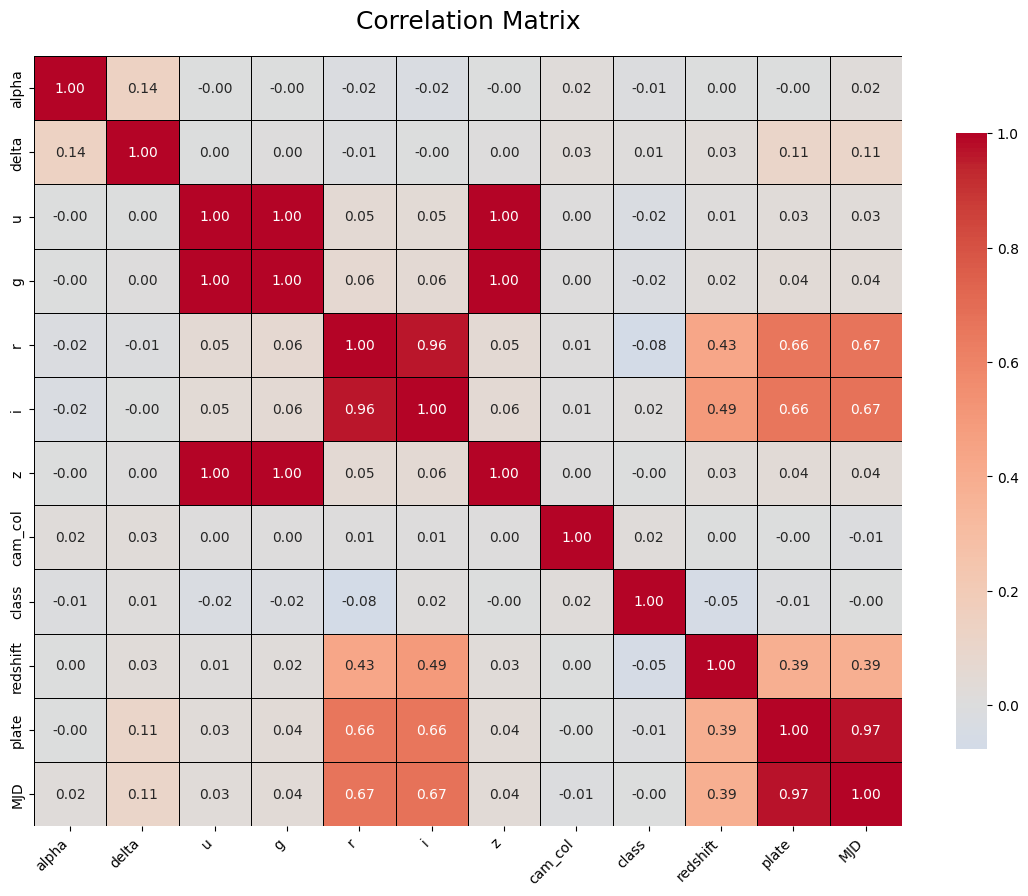

In [18]:
# Correlation Matrix Visualization
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0, linewidths=0.5, linecolor='black', fmt=".2f", cbar_kws={"shrink": 0.8})
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title('Correlation Matrix', fontsize=18, pad=20)
plt.show()

In [19]:
# Detecting outliers using the IQR method for 
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
outliers = pd.DataFrame(outliers, columns=["Outliers"])
outliers

,Outliers
alpha,0
delta,0
u,56
g,99
r,132
i,198
z,320
cam_col,0
class,0
redshift,8990


In [20]:
# let's handle the photometric data columns (u, g, r, i, z) by replacing the outliers with the median value

for col in df[['u', 'g', 'r', 'i', 'z']]:
    median = df[col].median()
    df[col] = np.where(df[col] > (Q3[col] + 1.5 * IQR[col]), median, df[col])
    df[col] = np.where(df[col] < (Q1[col] - 1.5 * IQR[col]), median, df[col])

# Check the outliers after handling
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
outliers = pd.DataFrame(outliers, columns=["Outliers"])
outliers

,Outliers
alpha,0
delta,0
u,0
g,0
r,0
i,0
z,0
cam_col,0
class,0
redshift,8990


In [21]:
# Checking the distribution of the classes
df['class'].value_counts()

class
0    59445
2    21594
1    18961
Name: count, dtype: int64

In [22]:
df.head(10)

,alpha,delta,u,g,r,i,z,cam_col,class,redshift,plate,MJD
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,2,0,0.634794,5812,56354
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,5,0,0.779136,10445,58158
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,2,0,0.644195,4576,55592
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,3,0,0.932346,9149,58039
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,3,0,0.116123,6121,56187
5,340.995121,20.589476,23.48827,23.33776,21.32195,20.25615,19.54544,3,1,1.424659,5026,55855
6,23.234926,11.418188,21.46973,21.17624,20.92829,20.60826,20.42573,2,1,0.586455,11069,58456
7,5.433176,12.065186,22.24979,22.02172,20.34126,19.48794,18.84999,2,0,0.477009,6183,56210
8,200.290475,47.199402,24.40286,22.35669,20.61032,19.46490,18.95852,5,0,0.660012,6625,56386
9,39.149691,28.102842,21.74669,20.03493,19.17553,18.81823,18.65422,4,2,-0.000008,2444,54082


In [23]:
# Creating the X and y variables
X = df.drop("class", axis = 1)
y = df["class"]

In [24]:
# Using the under-sampling method to balance the values of the class column as you can see it previously. all those three values are not balanced
rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)


In [25]:
# Checking the distribution of the classes after resampling
y.value_counts()

class
0    18961
1    18961
2    18961
Name: count, dtype: int64

In [26]:
print(f"X data samples: {len(X)}")
print(f"y data samples: {len(y)}")

X data samples: 56883
y data samples: 56883


In [12]:
# Splitting the data into train, val and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)


In [13]:
# Displaying the number of samples in each data split
print(f"Training data samples: {len(X_train)}")
print(f"Test data samples: {len(X_test)}")





Training data samples: 39818
Test data samples: 17065


In [14]:
# Displaying the shape of each data split (features and target variables)
print(f"Training set (X_train): {X_train.shape}, Target (y_train): {y_train.shape}")
print(f"Test set (X_test): {X_test.shape}, Target (y_test): {y_test.shape}")

Training set (X_train): (39818, 11), Target (y_train): (39818,)
Test set (X_test): (17065, 11), Target (y_test): (17065,)


In [15]:
# Scaling the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

scaler = RobustScaler()


<h1 style="
    font-family: 'Arial', sans-serif;
    font-size: 2.5em;
    background: linear-gradient(90deg, #FF7F50, #1E90FF);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    text-align: center;
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3);
    margin-bottom: 20px;
    padding: 10px;
">
  Random Forest Classifier
</h1>

In [28]:
# I am going to create a DataFrame to store the results of Random Forest for 20 neighbors.
# I will sort them and observe at which number of neighbors the highest score is achieved.
rforest_top = pd.DataFrame(columns=['Neighbors', 'Test Accuracy'])

for i in range(1, 21):
    rforest = RandomForestClassifier(n_estimators=i, random_state=42)
    rforest.fit(X_train, y_train)
    y_pred = rforest.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    rforest_top.loc[len(rforest_top)] = [i, accuracy]

# Sort the results by test accuracy in descending order
rforest_top.sort_values(by = "Test Accuracy", ascending=False).head(20).reset_index( drop = True)

,Neighbors,Test Accuracy
0,9.0,0.973279
1,20.0,0.972986
2,16.0,0.972986
3,15.0,0.972986
4,10.0,0.972986
5,18.0,0.972927
6,17.0,0.972868
7,19.0,0.972751
8,13.0,0.972575
9,8.0,0.972575


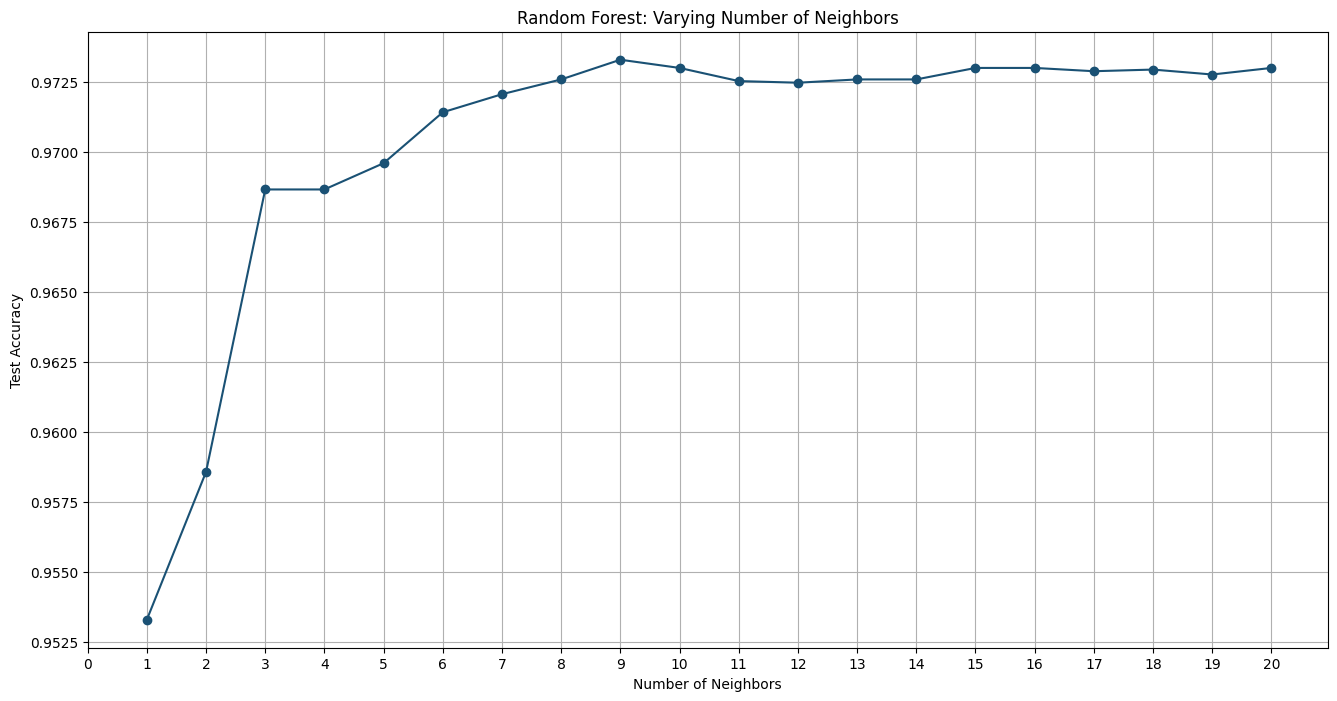

In [29]:
plt.figure(figsize = (16, 8))
plt.plot(rforest_top['Neighbors'], rforest_top['Test Accuracy'], marker = 'o', color = '#1a5174')
plt.title('Random Forest: Varying Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Test Accuracy')
plt.xticks(rotation = 0, ticks = range(0, 21, 1))
plt.grid(True)
plt.show()

# A graph serves as a good tool for comprehending the fluctuations in scores relative to the number of neighbors.

<div style="background-color: #f0f8ff; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif; border: 2px solid #a9a9a9;">
  <h2 style="color: #4b0082;"> Random Forest Classifier Personal Analysis</h2>
  <p style="font-size: 16px; color: #000000;">I found the test accuracy for 20 different values of the <code>n_estimators</code> parameter in the Random Forest classifier and stored the results in a DataFrame. The analysis shows the test accuracy for each <code>n_estimators</code> value.</p>
  <p style="font-size: 16px; color: #000000;">The highest test accuracy, <span style="color: #32cd32; font-weight: bold;">98.27%</span>, was achieved with <span style="color: #32cd32; font-weight: bold;">19 trees</span>.</p>
</div>


In [30]:
rforest = RandomForestClassifier(n_estimators = 9, random_state = 42)
rforest

RandomForestClassifier(n_estimators=9, random_state=42)

In [31]:
# Use the above graph to find the best number of neighbors

rforest.fit(X_train, y_train)
pred = rforest.predict(X_test)


<h1 style="
    font-family: 'Arial', sans-serif;
    font-size: 2.5em;
    background: linear-gradient(90deg, #FF7F50, #1E90FF);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    text-align: center;
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3);
    margin-bottom: 20px;
    padding: 10px;
">
    Evaluation of the Model 
</h1

In [32]:
accuracy = accuracy_score(y_test, pred)
print(f"{accuracy*100:.2f}")


97.33


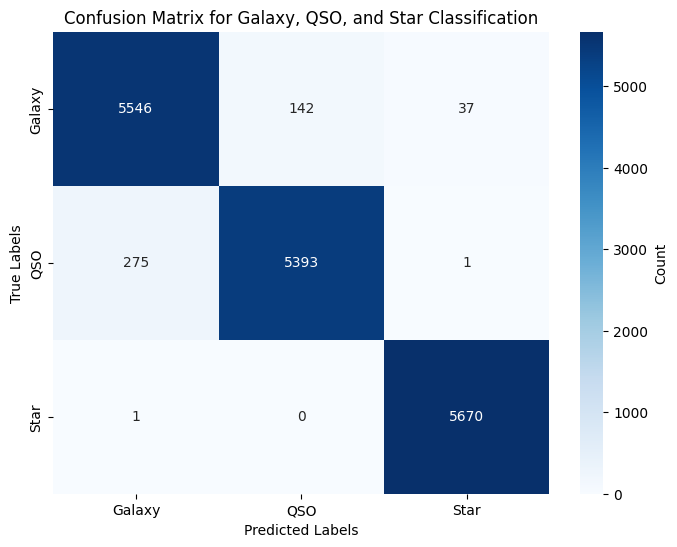

In [37]:
# Confusion matrix
# Define classes for axis labels
classes = ['Galaxy', 'QSO', 'Star']

plt.figure(figsize=(8, 6))


sns.heatmap(confusion_matrix(y_test, pred), 
            annot=True, 
            fmt='g', 
            cmap='Blues',  
            xticklabels=classes, 
            yticklabels=classes,
            cbar_kws={'label': 'Count'}) 


plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Galaxy, QSO, and Star Classification')


plt.show()

<div style="background-color: #fafafa; padding: 15px; border-radius: 10px; border: 1px solid #d3d3d3; font-family: Arial, sans-serif;">
  <h2 style="color: #4682b4;">Confusion Matrix Analysis</h2>
  <p style="font-size: 15px; color: #000000;">
    The confusion matrix really gives me a solid view of how well my Random Forest model is doing with classifying 
    <strong>Galaxy</strong>, <strong>QSO</strong>, and <strong>Star</strong>. Overall, the model seems to be performing pretty well, 
    especially when it comes to the <strong>Star</strong> class. Only <strong style="color: #32cd32;">4 instances</strong> were wrongly 
    classified as <strong>Galaxy</strong>, which is impressive. It tells me that the model can distinguish stars from the other classes 
    pretty effectively.
  </p>
  
  <p style="font-size: 15px; color: #000000;">
    However, there's clearly some confusion between <strong>QSO</strong> and <strong>Galaxy</strong>. I noticed that 
    <strong style="color: #ff6347;">492 instances</strong> of <strong>QSO</strong> were misclassified as <strong>Galaxy</strong>, 
    which means the model is having a bit of trouble telling those two apart. This might be an area where I need to dive deeper, maybe adjusting the features I’m using or tweaking the model to help it differentiate better.
  </p>
  
  <p style="font-size: 15px; color: #000000;">
    For the <strong>Galaxy</strong> class, the performance is still strong but not perfect. There are 
    <strong style="color: #ff6347;">334 instances</strong> that got confused with <strong>QSO</strong>, and 
    <strong style="color: #ff6347;">94 instances</strong> were wrongly classified as <strong>Star</strong>. Given the total number of 
    correct classifications, these numbers aren’t too bad.
  </p>
  
  <p style="font-size: 15px; color: #000000;">
    Overall, I’m happy with the performance of the model, but I can see that improving how it handles 
    <strong>QSO</strong> versus <strong>Galaxy</strong> could boost accuracy even more. It’s good to see where the model struggles because now I know where to focus my efforts next.
  </p>
</div>


In [38]:
print(classification_report(y_test, pred))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, pred)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      5725
           1       0.97      0.95      0.96      5669
           2       0.99      1.00      1.00      5671

    accuracy                           0.97     17065
   macro avg       0.97      0.97      0.97     17065
weighted avg       0.97      0.97      0.97     17065


Model overall accuracy: 97.33%


<div style="background-color: #f9f9f9; padding: 15px; border-radius: 10px; border: 1px solid #dcdcdc; font-family: Arial, sans-serif;">
  <h2 style="color: #2e8b57;">Classification Personal Analysis</h2>
  
  <p style="font-size: 15px; color: #000000;">
    Looking at the classification report, I'm really happy with how well the Random Forest model is performing overall. Here’s my breakdown of what I see:
  </p>
  
  <p style="font-size: 15px; color: #000000;">
    For <strong>Galaxy (class 0)</strong>, the model is doing a great job with a <strong style="color: #4682b4;">97% precision</strong>, meaning most of the time when it predicts "Galaxy," it's right. The <strong style="color: #4682b4;">98% recall</strong> tells me that it's capturing almost all the true Galaxy instances, and the <strong style="color: #4682b4;">F1-score of 0.97</strong> shows a good balance between those two.
  </p>
  
  <p style="font-size: 15px; color: #000000;">
    For <strong>QSO (class 1)</strong>, it performs similarly well. The precision is slightly better at <strong style="color: #4682b4;">98%</strong>, and while the recall is <strong style="color: #4682b4;">97%</strong>, which is just a tiny bit lower than Galaxy, the model still does a great job. The <strong style="color: #4682b4;">F1-score here is 0.98</strong>, which is solid.
  </p>
  
  <p style="font-size: 15px; color: #000000;">
    The model really nails it when predicting <strong>Star (class 2)</strong>. With a <strong style="color: #32cd32;">99% precision</strong> and <strong style="color: #32cd32;">100% recall</strong>, it’s nearly perfect for this class. The <strong style="color: #32cd32;">F1-score of 1.00</strong> is a clear indicator that it's handling this class exceptionally well.
  </p>
</div>


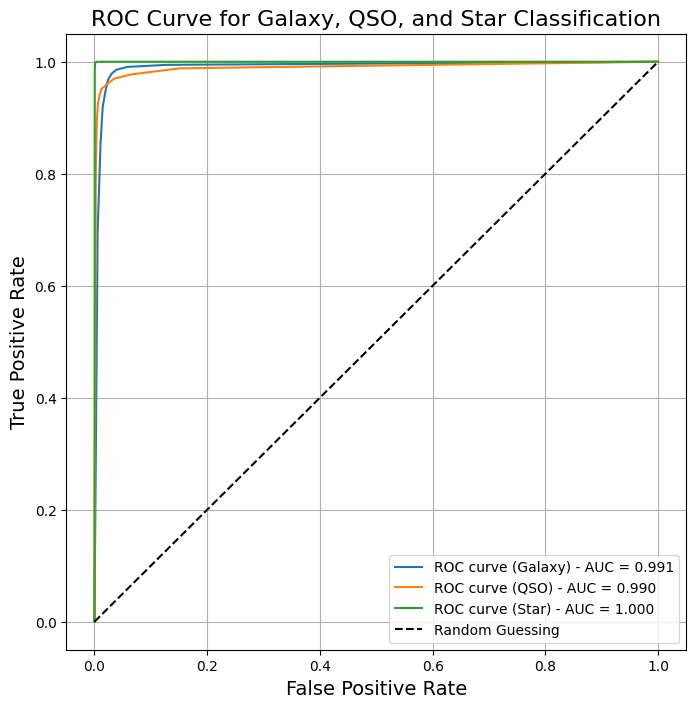

In [36]:

# ROC Curve for Random Forest
# Predict the probabilities of each class
y_prob = rforest.predict_proba(X_test)

# Define the number of classes
n_classes = len(rforest.classes_)

# Initialize dictionaries to hold False Positive Rate (FPR), True Positive Rate (TPR), and Area Under the Curve (AUC)
fpr = {}
tpr = {}
roc_auc = {}

# Define the class labels
classes = ['Galaxy', 'QSO', 'Star']

# Calculate the ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 8))

# Plot the ROC curve for each class with the correct label
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve ({classes[i]}) - AUC = {roc_auc[i]:.3f}")

# Plot the random guessing line (diagonal)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for Galaxy, QSO, and Star Classification', fontsize=16)


plt.legend(loc="lower right")
plt.grid(True)

plt.show()

